# FastF1 Examples

This notebook demonstrates some of the capabilities of FastF1, including the visualizations you can make with the results.

### Setup

In [ ]:
!pip install fastf1

In [2]:
import fastf1
import fastf1.plotting
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd
from fastf1.core import Laps

# enable some matplotlib patches for plotting timedelta values and load
# FastF1's default color scheme
fastf1.plotting.setup_mpl()

# setup caching
CACHE_DIR = "./cache"
Path(CACHE_DIR).mkdir(exist_ok=True)
fastf1.Cache.enable_cache(CACHE_DIR)

## Load data

In [3]:
session = fastf1.get_session(2021, 'Austrian Grand Prix', 'Q')
session.load()

lap = session.laps.pick_fastest()
tel = lap.get_telemetry()

core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '4', '11', '44', '77', '10', '22', '5', '63', '18', '55', '16', '3', '14', '99', '7', '31', '6', '47', '9']


## Qualifying results

Plot the fastest times for the qualifying results.

### Get data for drivers

In [4]:
##############################################################################
# First, we need to get an array of all drivers.

drivers = pd.unique(session.laps['Driver'])
print(drivers)

##############################################################################
# After that we'll get each drivers fastest lap, create a new laps object
# from these laps, sort them by lap time and have pandas reindex them to
# number them nicely by starting position.

list_fastest_laps = list()
for drv in drivers:
    drvs_fastest_lap = session.laps.pick_driver(drv).pick_fastest()
    list_fastest_laps.append(drvs_fastest_lap)
fastest_laps = Laps(list_fastest_laps).sort_values(by='LapTime').reset_index(drop=True)

##############################################################################
# The plot is nicer to look at and more easily understandable if we just plot
# the time differences. Therefore we subtract the fastest lap time from all
# other lap times.

pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']


##############################################################################
# We can take a quick look at the laps we have to check if everything
# looks all right. For this, we'll just check the 'Driver', 'LapTime'
# and 'LapTimeDelta' columns.

print(fastest_laps[['Driver', 'LapTime', 'LapTimeDelta']])


['VER' 'NOR' 'PER' 'HAM' 'BOT' 'GAS' 'TSU' 'VET' 'RUS' 'STR' 'SAI' 'LEC'
 'RIC' 'ALO' 'GIO' 'RAI' 'OCO' 'LAT' 'MSC' 'MAZ']
   Driver                LapTime           LapTimeDelta
0     VER 0 days 00:01:03.720000        0 days 00:00:00
1     NOR 0 days 00:01:03.768000 0 days 00:00:00.048000
2     PER 0 days 00:01:03.990000 0 days 00:00:00.270000
3     HAM 0 days 00:01:04.014000 0 days 00:00:00.294000
4     BOT 0 days 00:01:04.049000 0 days 00:00:00.329000
5     GAS 0 days 00:01:04.107000 0 days 00:00:00.387000
6     TSU 0 days 00:01:04.273000 0 days 00:00:00.553000
7     SAI 0 days 00:01:04.559000 0 days 00:00:00.839000
8     VET 0 days 00:01:04.570000 0 days 00:00:00.850000
9     RUS 0 days 00:01:04.591000 0 days 00:00:00.871000
10    LEC 0 days 00:01:04.600000 0 days 00:00:00.880000
11    STR 0 days 00:01:04.618000 0 days 00:00:00.898000
12    RIC 0 days 00:01:04.719000 0 days 00:00:00.999000
13    ALO 0 days 00:01:04.856000 0 days 00:00:01.136000
14    RAI 0 days 00:01:05.009000 0 da

### Plot the qualifying results

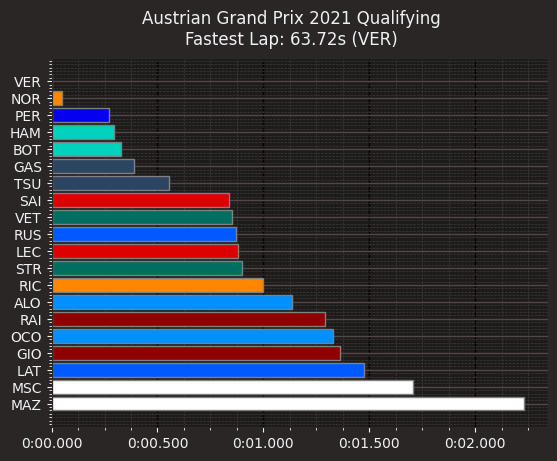

In [5]:
##############################################################################
# Finally, we'll create a list of team colors per lap to color our plot.
team_colors = list()
for index, lap in fastest_laps.iterlaps():
    color = fastf1.plotting.team_color(lap['Team'])
    team_colors.append(color)


##############################################################################
# Now, we can plot all the data
fig, ax = plt.subplots()
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)
# sphinx_gallery_defer_figures


##############################################################################
# Finally, give the plot a meaningful title

plt.suptitle(f"{session.event['EventName']} {session.event.year} Qualifying\n"
             f"Fastest Lap: {pole_lap['LapTime'].total_seconds()}s ({pole_lap['Driver']})")

plt.show()


## Speed traces

Compare two fastest laps by overlaying their speed traces.

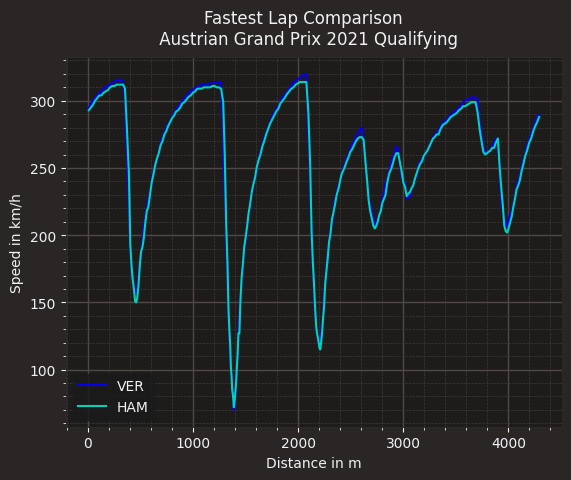

In [6]:
##############################################################################
# First, we select the two laps that we want to compare

ver_lap = session.laps.pick_driver('VER').pick_fastest()
ham_lap = session.laps.pick_driver('HAM').pick_fastest()

##############################################################################
# Next we get the telemetry data for each lap. We also add a 'Distance' column
# to the telemetry dataframe as this makes it easier to compare the laps.

ver_tel = ver_lap.get_car_data().add_distance()
ham_tel = ham_lap.get_car_data().add_distance()

##############################################################################
# Finally, we create a plot and plot both speed traces.
# We color the individual lines with the driver's team colors.

rbr_color = fastf1.plotting.team_color('RBR')
mer_color = fastf1.plotting.team_color('MER')

fig, ax = plt.subplots()
ax.plot(ver_tel['Distance'], ver_tel['Speed'], color=rbr_color, label='VER')
ax.plot(ham_tel['Distance'], ham_tel['Speed'], color=mer_color, label='HAM')

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

ax.legend()
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{session.event['EventName']} {session.event.year} Qualifying")

plt.show()


## Gear shifts on track

Plot which gear is being used at which point of the track

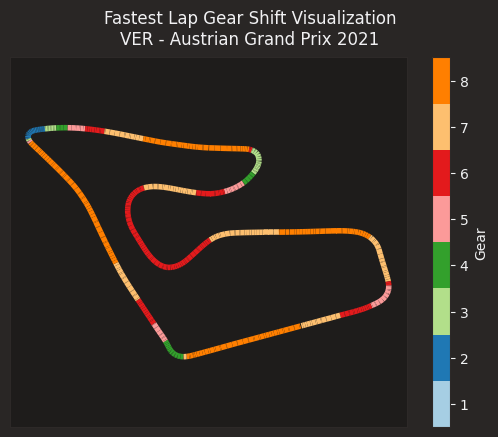

In [7]:
lap = session.laps.pick_fastest()
tel = lap.get_telemetry()

##############################################################################
# Prepare the data for plotting by converting it to the appropriate numpy
# data types

x = np.array(tel['X'].values)
y = np.array(tel['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
gear = tel['nGear'].to_numpy().astype(float)
# sphinx_gallery_defer_figures

##############################################################################
# Create a line collection. Set a segmented colormap and normalize the plot
# to full integer values of the colormap

cmap = cm.get_cmap('Paired')
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(gear)
lc_comp.set_linewidth(4)
# sphinx_gallery_defer_figures

##############################################################################
# Create the plot

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

title = plt.suptitle(
    f"Fastest Lap Gear Shift Visualization\n"
    f"{lap['Driver']} - {session.event['EventName']} {session.event.year}"
)

##############################################################################
# Add a colorbar to the plot. Shift the colorbar ticks by +0.5 so that they
# are centered for each color segment.

cbar = plt.colorbar(mappable=lc_comp, label="Gear", boundaries=np.arange(1, 10))
cbar.set_ticks(np.arange(1.5, 9.5))
cbar.set_ticklabels(np.arange(1, 9))

plt.show()